<a href="https://colab.research.google.com/github/tupoylogin/segmentation_test_task/blob/master/iMaterialist_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu==1.15.0
!pip install keras==2.2.5

     |████████████████████████████████| 411.5MB 39kB/s 


In [0]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [3]:
!cd ../kaggle

/bin/bash: line 0: cd: ../kaggle: No such file or directory


In [4]:
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config path -p /content
!kaggle competitions download -c imaterialist-fashion-2019-FGVC6

usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')
  0% 0.00/318k [00:00<?, ?B/s]
100% 318k/318k [00:00<00:00, 44.0MB/s]
  0% 0.00/58.8k [00:00<?, ?B/s]
100% 58.8k/58.8k [00:00<00:00, 60.6MB/s]
  0% 0.00/143k [00:00<?, ?B/s]
100% 143k/143k [00:00<00:00, 46.2MB/s]
  0% 0.00/351k [00:00<?, ?B/s]
100% 351k/351k [00:00<00:00, 107MB/s]
  0% 0.00/38.1k [00:00<?, ?B/s]
100% 38.1k/38.1k [00:00<00:00, 33.5MB/s]
  0% 0.00/799k [00:00<?, ?B/s]
100% 799k/799k [00:00<00:00, 53.3MB/s]
  0% 0.00/139k [00:00<?, ?B/s]
100% 139k/139k [00:00<00:00, 125MB/s]
  0% 0.00/0.98M [00:00<?, ?B/s]
100% 0.98M/0.98M [00:00<00:00, 140MB/s]
  0% 0.00/276k [00:00<?, ?B/s]
100% 276k/276k [00:00<00:00, 89.4MB/s]
  0% 0.00/874k [00:00<?, ?B/s]
100% 874k/874k [00:00<00:00, 122MB/s]
  0% 0.00/75.2k [00:00<?, ?B/s]
100% 75.2k/75.2k [00:00<00:00, 75.1MB/s]
  0% 0.00/754k [00:00<?, ?B/s]
100% 754k/754k [00:00<00:00, 106MB/s]
  0% 0

In [0]:
%matplotlib inline
import os
import gc
import sys
import json
import glob
import random 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
# Any results you write to the current directory are saved as output.

Используем **mask_rcnn** для сегментации. Проверим как сеть переобучится на двух архитектурах.

In [6]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
!pip install -q git+https://github.com/tensorflow/examples.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.83 MiB | 29.65 MiB/s, done.
Resolving deltas: 100% (569/569), done.


In [0]:
zipped = []
fn = []
for dirname, _, filenames in os.walk('/content'):
  for filename in filenames:
    if filename.endswith('zip'):
      zipped.append(os.path.join(dirname, filename))
    elif filename.endswith('jpg'):
      fn.append(filename)

In [0]:
import zipfile 
for file in zipped:
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

In [0]:
os.chdir('Mask_RCNN')
DATA_DIR = Path('/content/')
ROOT_DIR = Path('/kaggle/working')

Импортируем модули из репо сетки

In [10]:
%tensorflow_version 1.x 
sys.path.append(str(ROOT_DIR/'Mask_RCNN'))

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

Using TensorFlow backend.


-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


Задаем конфигурацию сети, то есть ее тип, архитектуру, размер входщего изображеня, количество классов

In [41]:
# config: either 'resnet50' or 'resnet101' is supported

NUM_CATS = 46
IMAGE_SIZE = 512

class Config_(Config):
    def __init__(self, bbone):
        super().__init__()
        self.BACKBONE = bbone 
        
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # background
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 
    
    
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
config = Config_(bbone='resnet50')
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [0]:
with open(DATA_DIR/"label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

segment_df = pd.read_csv(DATA_DIR/"train.csv")
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

multilabel_percent = len(segment_df[segment_df['CategoryId'].str.contains('_')])/len(segment_df)*100

In [13]:
segment_df.head(10)

,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32
5,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,11464158 10 11469372 30 11474586 43 11479800 4...,5214,3676,32,32
6,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,5910568 31 5915775 65 5920982 69 5926189 73 59...,5214,3676,31,31
7,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6421446 292 6426657 298 6431867 305 6437078 31...,5214,3676,29,29
8,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,4566382 8 4571592 25 4576803 41 4582013 58 458...,5214,3676,4,4
9,0000fe7c9191fba733c8a69cfaf962b7.jpg,2201176 1 2203623 3 2206071 5 2208518 8 221096...,2448,2448,33,33


In [0]:
segment_df = segment_df[segment_df['ImageId'].isin(fn)]

In [15]:
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

Total images:  19


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500


In [0]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

Утилиты для работы с датасетом. Прогрузка каждого изображения, маски для сегментации и пр.

In [0]:
class Dataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_DIR/row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

('/content/00048c3a2fb9c29340473c4cfc06424a.jpg', ['glasses', 'top, t-shirt, sweatshirt', 'neckline', 'skirt', 'zipper', 'bag, wallet', 'shoe', 'shoe'])


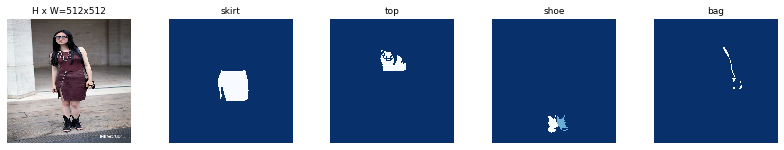

In [18]:
dataset = Dataset(image_df)
dataset.prepare()


image_id = random.choice(dataset.image_ids)
print(dataset.image_reference(image_id))
    
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

Тут будет кроссвалидация

In [0]:
from sklearn.model_selection import KFold

FOLD = 0
N_FOLDS = 10

kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

train_dataset = Dataset(train_df)
train_dataset.prepare()

valid_dataset = Dataset(valid_df)
valid_dataset.prepare()

Total train images:  17
Total train segments:  100


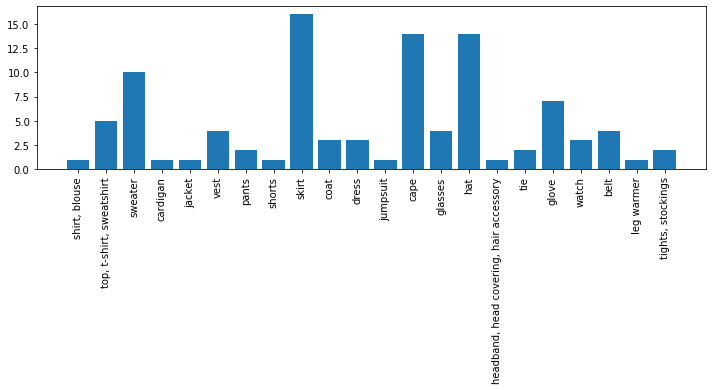

Total validation images:  2
Total validation segments:  17


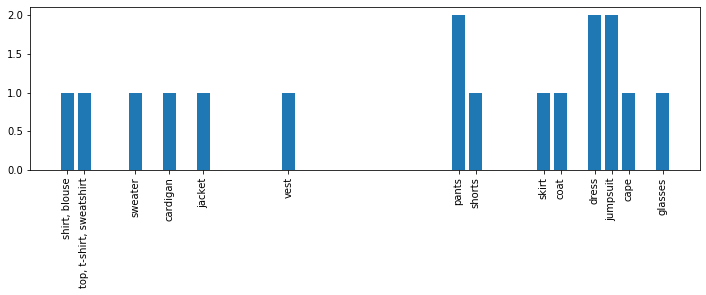

In [35]:
train_segments = np.concatenate(train_df['CategoryId'].values)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

valid_segments = np.concatenate(valid_df['CategoryId'].values).astype(int)
print("Total validation images: ", len(valid_df))
print("Total validation segments: ", len(valid_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(valid_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

In [0]:
LR = 1e-3
EPOCHS = [2, 6, 8]

Обучаем первую сетку (резнет 50). Выбираем наилучшие показатели, чтобы откатиться потом к тем наборам весов

In [22]:
model_1 = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model_1.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [0]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5) 
])

In [24]:
model_1.train(train_dataset, valid_dataset,
            learning_rate=LR*2, # train heads with higher lr to speedup learning
            epochs=EPOCHS[0],
            layers='heads',
            augmentation=None)

history = model_1.keras_model.history.history


Starting at epoch 0. LR=0.002

Checkpoint Path: /kaggle/working/fashion20191222T1029/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4     

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/2
1000/1000 [==============================] - 901s 901ms/step - loss: 0.6381 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1222 - mrcnn_class_loss: 0.1170 - mrcnn_bbox_loss: 0.1578 - mrcnn_mask_loss: 0.2243 - val_loss: 8.7575 - val_rpn_class_loss: 0.4237 - val_rpn_bbox_loss: 5.4924 - val_mrcnn_class_loss: 1.3091 - val_mrcnn_bbox_loss: 0.4793 - val_mrcnn_mask_loss: 1.0530

Epoch 2/2
1000/1000 [==============================] - 776s 776ms/step - loss: 0.1671 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0906 - val_loss: 9.5918 - val_rpn_class_loss: 0.5096 - val_rpn_bbox_loss: 6.1995 - val_mrcnn_class_loss: 1.5481 - val_mrcnn_bbox_loss: 0.4990 - val_mrcnn_mask_loss: 0.8356


In [25]:
model_1.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS[1],
            layers='all',
            augmentation=augmentation)

new_history = model_1.keras_model.history.history


Starting at epoch 2. LR=0.001

Checkpoint Path: /kaggle/working/fashion20191222T1029/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b      

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 3/6
1000/1000 [==============================] - 1125s 1s/step - loss: 0.2876 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1144 - val_loss: 9.7625 - val_rpn_class_loss: 0.5605 - val_rpn_bbox_loss: 6.4587 - val_mrcnn_class_loss: 1.3013 - val_mrcnn_bbox_loss: 0.5117 - val_mrcnn_mask_loss: 0.9304
Epoch 4/6
1000/1000 [==============================] - 940s 940ms/step - loss: 0.1281 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0096 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.0781 - val_loss: 10.6647 - val_rpn_class_loss: 0.5873 - val_rpn_bbox_loss: 6.4199 - val_mrcnn_class_loss: 1.8172 - val_mrcnn_bbox_loss: 0.5705 - val_mrcnn_mask_loss: 1.2698
Epoch 5/6
1000/1000 [==============================] - 935s 935ms/step - loss: 0.0976 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0044 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0082 - mrcnn_mask_loss: 0.0669 - val_loss: 10.1241 - val

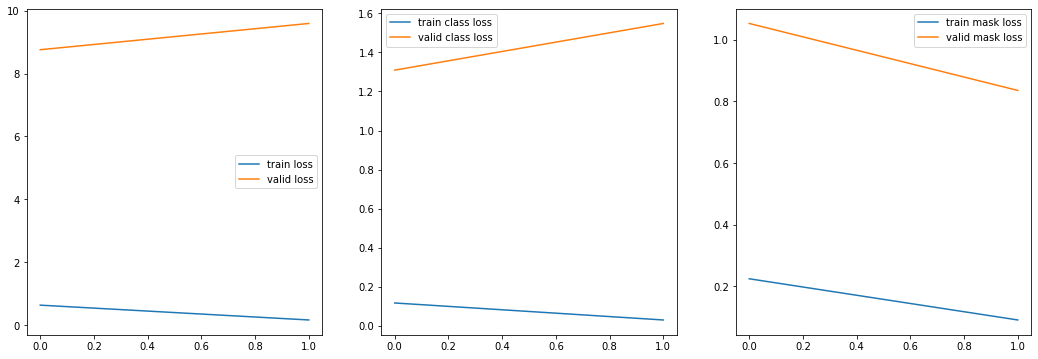

In [26]:
epochs = np.arange(EPOCHS[0])

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs,history['loss'], 
         label="train loss")
plt.plot(epochs, history['val_loss'], 
         label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

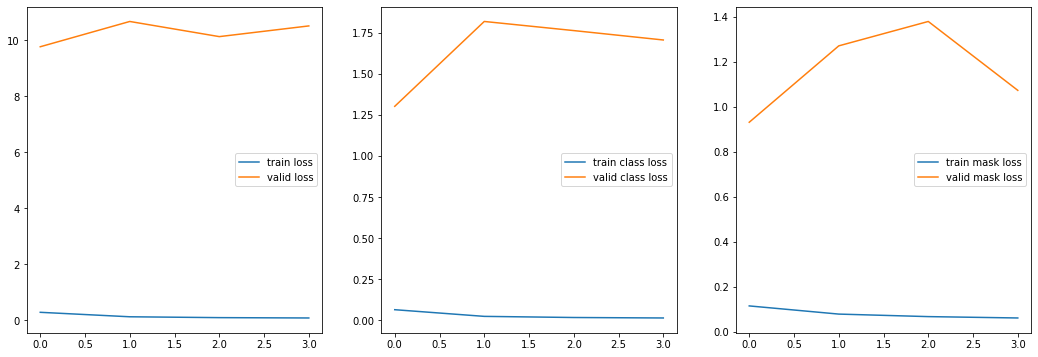

In [27]:
epochs = np.arange(4)

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs,new_history['loss'], 
         label="train loss")
plt.plot(epochs, new_history['val_loss'], 
         label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, new_history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, new_history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, new_history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, new_history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

Переобучение прошло успешно, судя по разнице в значениях функции потерь на тренировочных дааных и валидационных, что неудивительно при таком количестве параметров сети и размере тренировочного датасета. Однако лосс по отношению к классификации, а не сегментации, снижается как для тренировочных данных, так и для валидационных 

In [28]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

Best epoch:  1
Valid loss:  8.757496285438538


Попробуем большую архитектуру resnet-101

In [42]:
config = Config_('resnet101')
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

Теперь проделываем все то де с архитектурой на 101 слой

In [0]:
model_2 = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model_2.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [44]:
model_2.train(train_dataset, valid_dataset,
            learning_rate=LR*2, # train heads with higher lr to speedup learning
            epochs=EPOCHS[0],
            layers='heads',
            augmentation=None)

history = model_2.keras_model.history.history


Starting at epoch 0. LR=0.002

Checkpoint Path: /kaggle/working/fashion20191222T1406/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4     

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 1/2
1000/1000 [==============================] - 1106s 1s/step - loss: 0.6273 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.1410 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.1594 - mrcnn_mask_loss: 0.1999 - val_loss: 9.7372 - val_rpn_class_loss: 0.3876 - val_rpn_bbox_loss: 5.4874 - val_mrcnn_class_loss: 2.1022 - val_mrcnn_bbox_loss: 0.7879 - val_mrcnn_mask_loss: 0.9720
Epoch 2/2
1000/1000 [==============================] - 871s 871ms/step - loss: 0.1724 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0192 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.0866 - val_loss: 11.1205 - val_rpn_class_loss: 0.4515 - val_rpn_bbox_loss: 6.1055 - val_mrcnn_class_loss: 2.3062 - val_mrcnn_bbox_loss: 0.7869 - val_mrcnn_mask_loss: 1.4705



In [45]:
model_2.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS[1],
            layers='all',
            augmentation=augmentation)

new_history = model_2.keras_model.history.history


Starting at epoch 2. LR=0.001

Checkpoint Path: /kaggle/working/fashion20191222T1406/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b      

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 3/6
1000/1000 [==============================] - 1438s 1s/step - loss: 0.3246 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0708 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1197 - val_loss: 8.8714 - val_rpn_class_loss: 0.3905 - val_rpn_bbox_loss: 4.6455 - val_mrcnn_class_loss: 2.1488 - val_mrcnn_bbox_loss: 0.6235 - val_mrcnn_mask_loss: 1.0631
Epoch 4/6
1000/1000 [==============================] - 1239s 1s/step - loss: 0.1218 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0078 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0749 - val_loss: 8.7921 - val_rpn_class_loss: 0.3949 - val_rpn_bbox_loss: 4.4262 - val_mrcnn_class_loss: 2.1845 - val_mrcnn_bbox_loss: 0.6701 - val_mrcnn_mask_loss: 1.1164
Epoch 5/6
1000/1000 [==============================] - 1232s 1s/step - loss: 0.0879 - rpn_class_loss: 8.4727e-04 - rpn_bbox_loss: 0.0021 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0627 - val_loss: 9.2451 - val_r

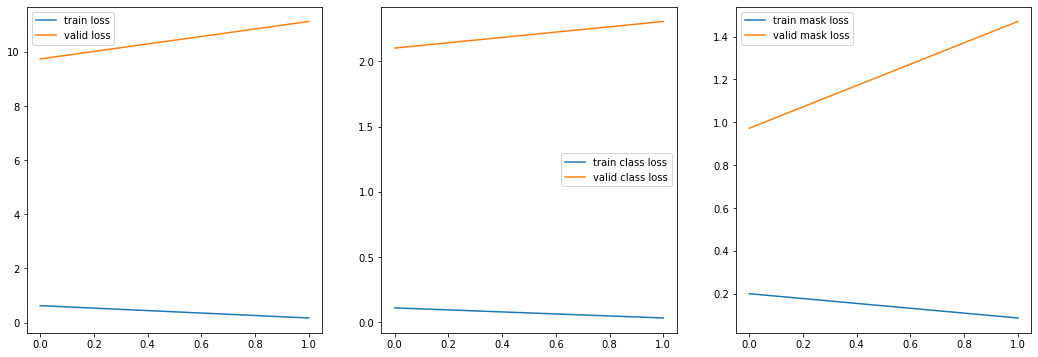

In [47]:
epochs = range(EPOCHS[0])

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

Как видим, при большей размерности сети разница в лоссе для тренировочных данных и валидационных еще больше

In [48]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

Best epoch:  1
Valid loss:  9.737150592803955


**Итог:** чем больше сеть - тем более она склонна к переобучению на сверхмалых объемах данных, так как обучаемых параметров в ней больше и соответственно она более гибкая в лане заучить тренировочный датасет.